## LINEAR MODELS
Compare values of hemispheres to structural values

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the csv
base_dir_linux =  f'/home/extop/GERARD/DATA/MAGNIMS2021/'
base_dir_win = f'C:/Users/gerar/Documents/graph_values/'

csv_cc = f'{base_dir_linux}/graph_values/cc.csv'
# csv_hemis = f'{base_dir_win}/graph_values/graph_intrainter_cort_G_SC.csv'
csv_hemis = f'{base_dir_linux}/graph_values/graph_dti_G_SC.csv'
csv_hemis_FC = f'{base_dir_linux}/graph_values/graph_G_FC.csv'
csv_hemis_nodes = f'{base_dir_linux}/graph_values/graph_nodes_SC.csv'
csv_total = f'{base_dir_linux}/data_total.csv'
extracted_values_path  = f'{base_dir_linux}/extracted_values.csv'

df_cc = pd.read_csv(csv_cc)
df_hemis = pd.read_csv(csv_hemis)
df_hemis_FC = pd.read_csv(csv_hemis_FC)
df_extracted = pd.read_csv(extracted_values_path)
df_hemis_nodes = pd.read_csv(csv_hemis_nodes)
df_total = pd.read_csv(csv_total)

In [5]:
# merge results and total
data_frames = [df_total, df_cc, df_hemis, df_extracted, df_hemis_FC]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=["SubjID", "CENTER"]), data_frames)

df_merged = df_merged[df_merged.QC == "Y"]

len(df_merged)
df_merged['disease'] = np.where(df_merged['GROUP']=='HC', "HC", "MS")

df_merged["Full_hemis"] = ( df_merged["SC_L_avg_spl"] + df_merged["SC_R_avg_spl"] ) / 2
df_merged["FC_spl_full"] = ( df_merged["FC_L_avg_spl"] + df_merged["FC_R_avg_spl"] ) / 2
df_merged["FC_eff_full"] = ( df_merged["FC_L_efficiency"] + df_merged["FC_R_efficiency"] ) / 2
df_merged["Full_CC"] = df_merged["CC_Posterior"] + df_merged["CC_Mid_Posterior"] + df_merged["CC_Central"] + df_merged["CC_Mid_Anterior"] + df_merged["CC_Anterior"]
df_merged["Comm_ratio_approx"] = ( df_merged["CC_Posterior"] + df_merged["CC_Mid_Posterior"] + df_merged["CC_Central"] + df_merged["CC_Mid_Anterior"] + df_merged["CC_Anterior"] ) / df_merged["EstimatedTotalIntraCranialVol"]
df_merged["CC_ratio_area"] = np.sqrt(df_merged["CC_Sag_area"]) / (df_merged["BrainSegVol"]**(1./3.))
df_merged["CC_Sag_area_sqrt"] = np.log10(np.sqrt(df_merged["CC_Sag_area"]))
df_merged["TIV_cubicroot"] = np.log10(df_merged["BrainSegVol"]**(1./3.))


In [6]:
# Normality analysis
from scipy import stats
from statsmodels import stats as st

list_of_variables_to_test = ["Full_hemis", "Comm_ratio", "CC_ratio_area", "EDSS", "SDMT", "BPF", "LVF", "RDlwm_mean", "FAlwm_mean"]
for x in list_of_variables_to_test:
    print(x)
    if x not in ["EDSS", "SDMT"]:
        test = stats.shapiro(df_merged[x].values)
    else:
        test = st.diagnostic.kstest_normal(df_merged[x].values)
    print(test)

Full_hemis
ShapiroResult(statistic=0.8001360297203064, pvalue=6.048858454303135e-29)
Comm_ratio
ShapiroResult(statistic=0.8894712924957275, pvalue=2.3206551075433233e-22)
CC_ratio_area
ShapiroResult(statistic=0.9653254747390747, pvalue=4.4465498991175245e-12)
EDSS
(nan, nan)
SDMT
(nan, nan)
BPF
ShapiroResult(statistic=0.9896582961082458, pvalue=5.5014250392559916e-05)
LVF
ShapiroResult(statistic=0.4067951440811157, pvalue=2.1720126197034665e-43)
RDlwm_mean
ShapiroResult(statistic=0.9634809494018555, pvalue=1.826390384415677e-12)
FAlwm_mean
ShapiroResult(statistic=0.9909572005271912, pvalue=0.00020052274339832366)


<AxesSubplot:xlabel='CC_ratio_area', ylabel='RDlwm_mean'>

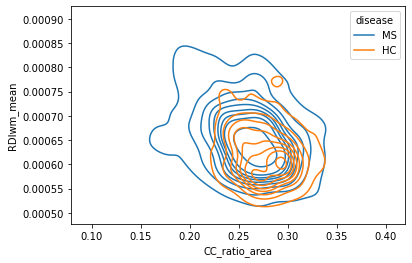

In [7]:
# direct analysis of CC_ratio_area
sns.kdeplot(data=df_merged, x="CC_ratio_area", y="RDlwm_mean", hue="disease")

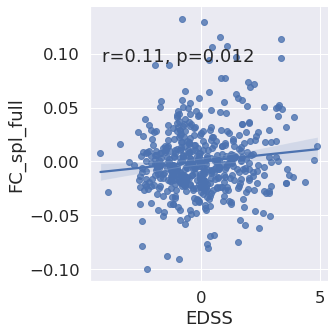

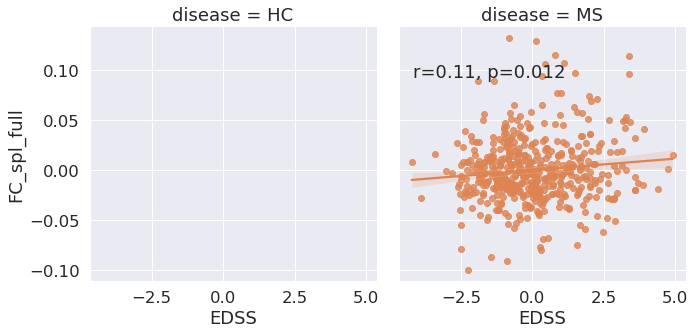

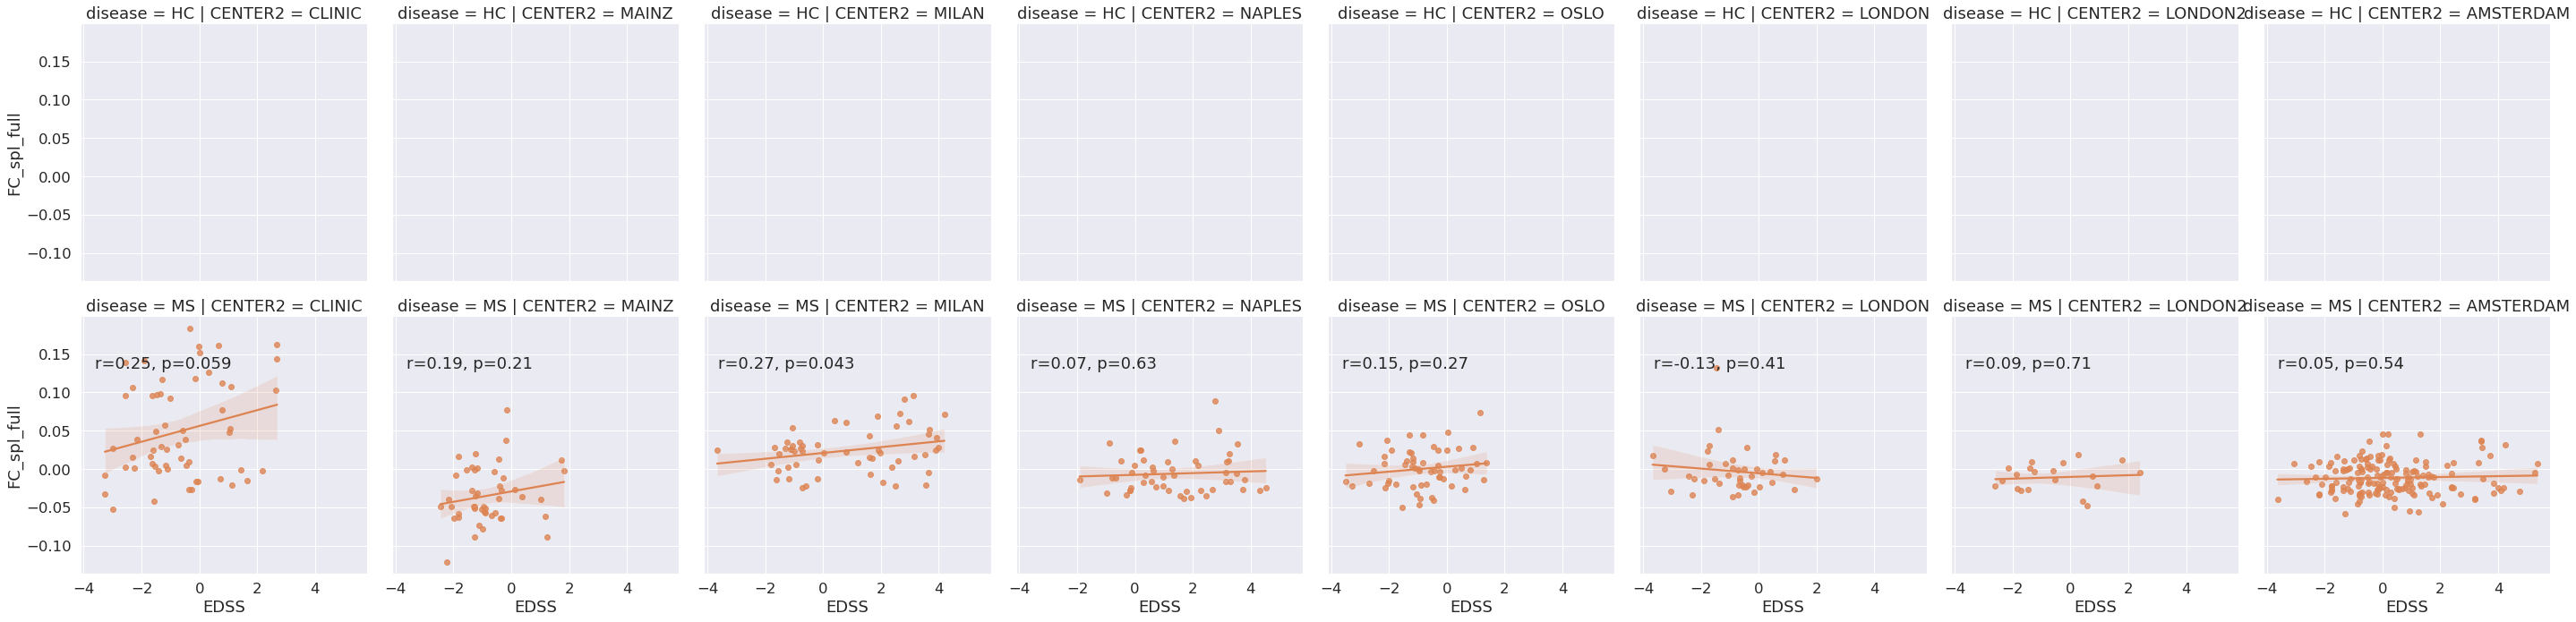

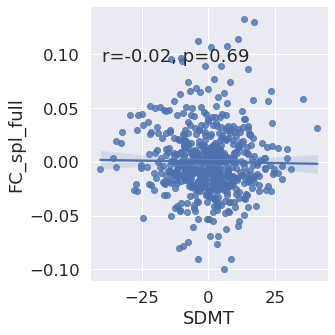

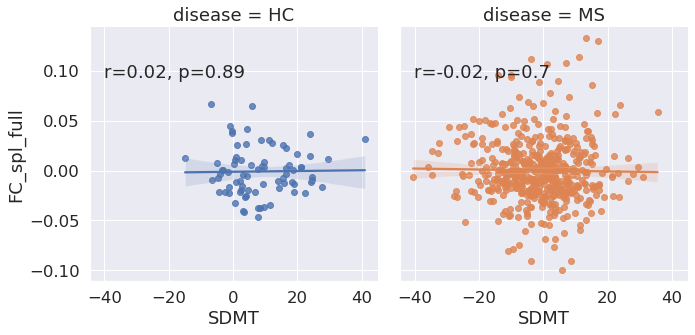

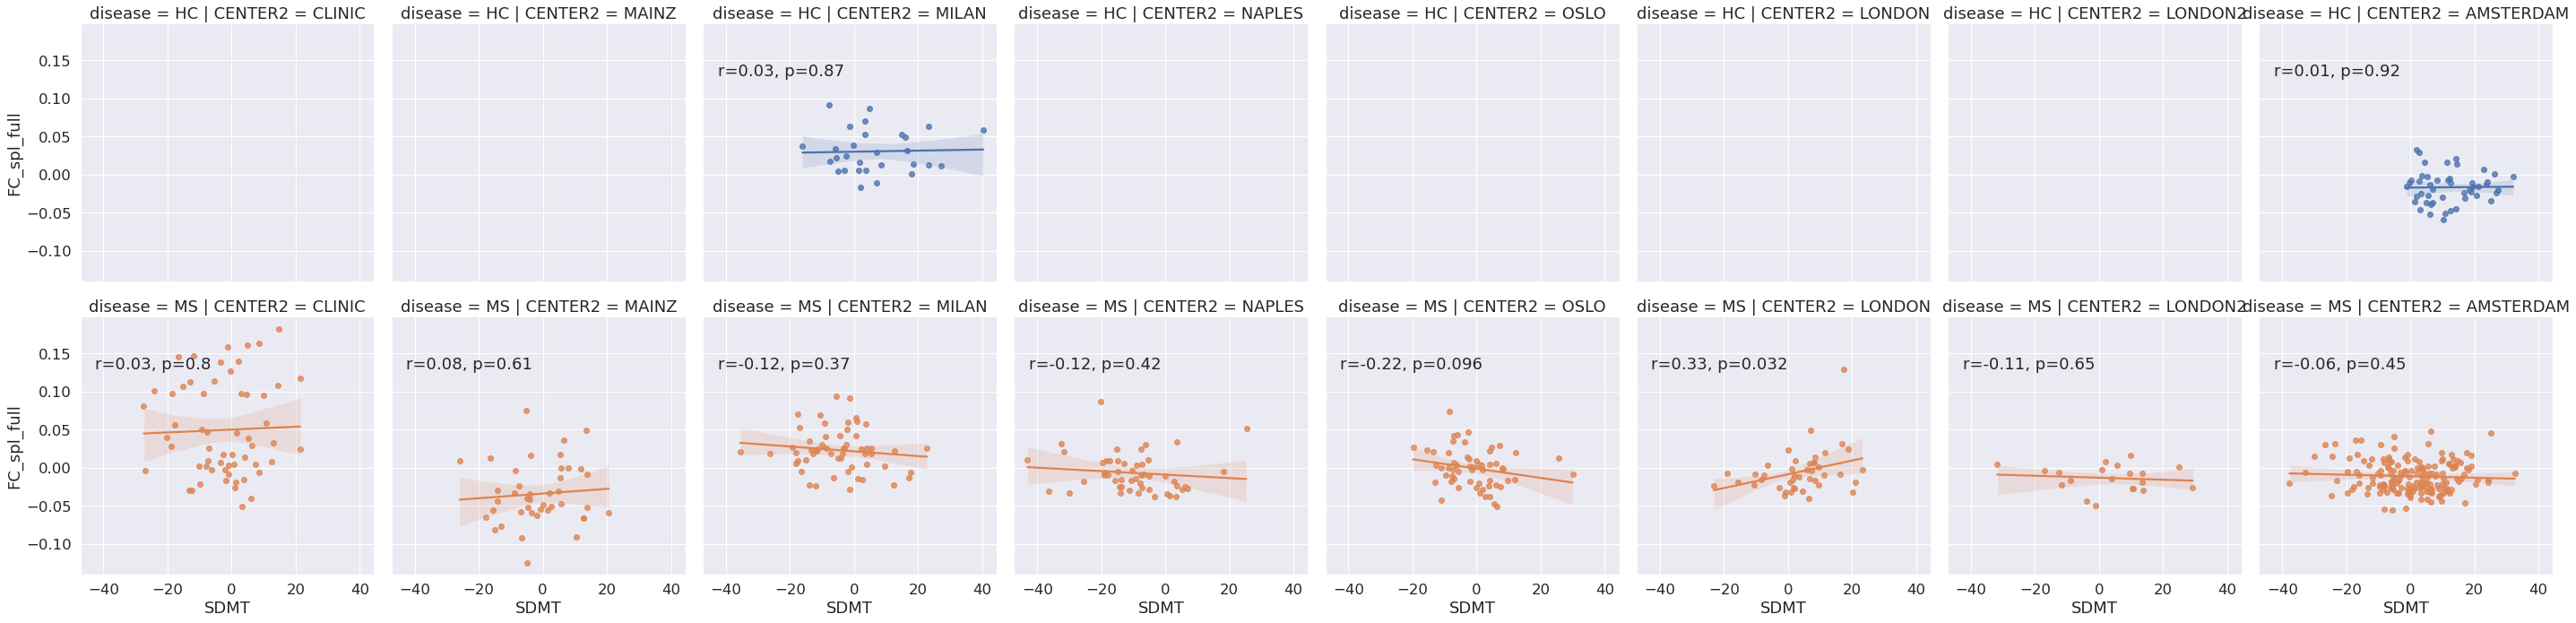

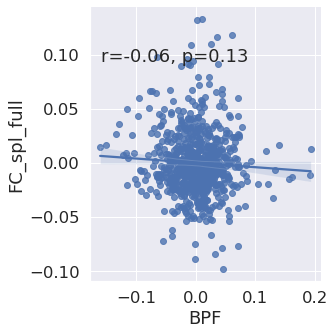

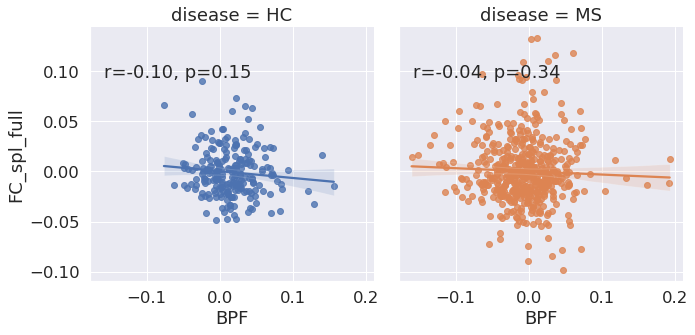

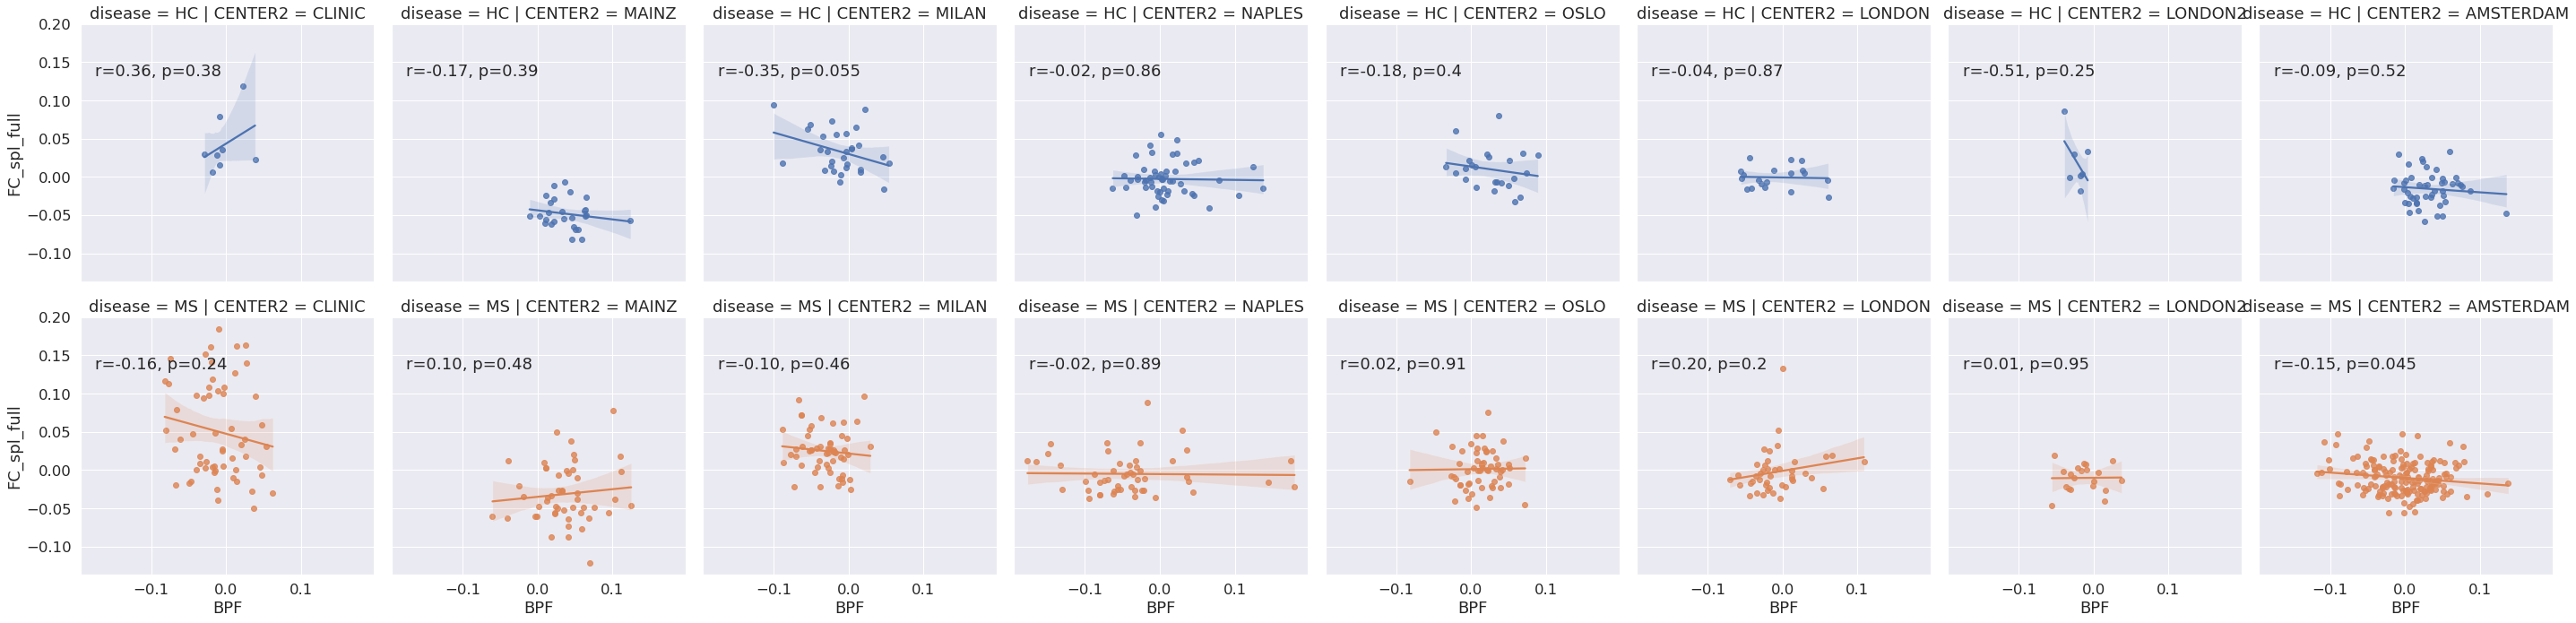

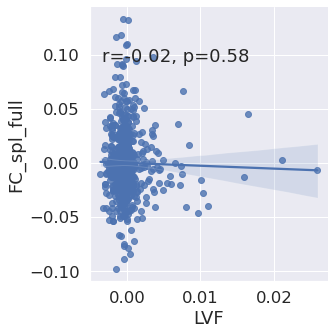

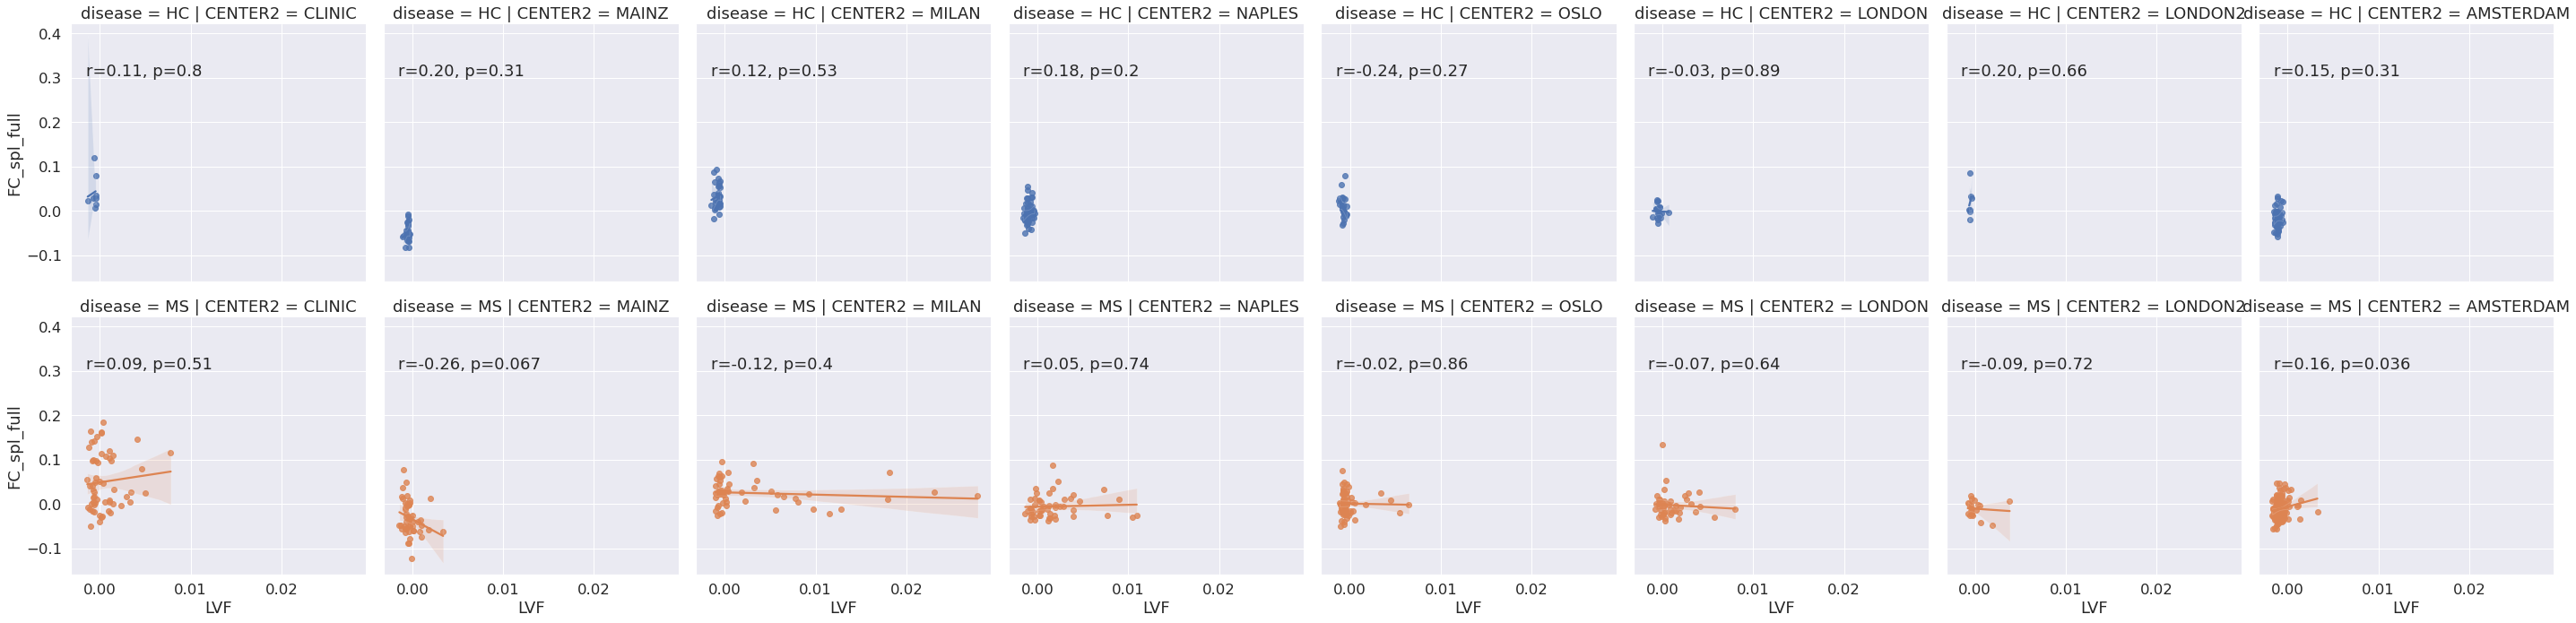

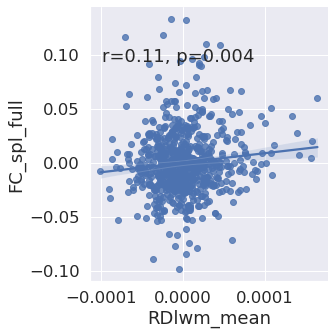

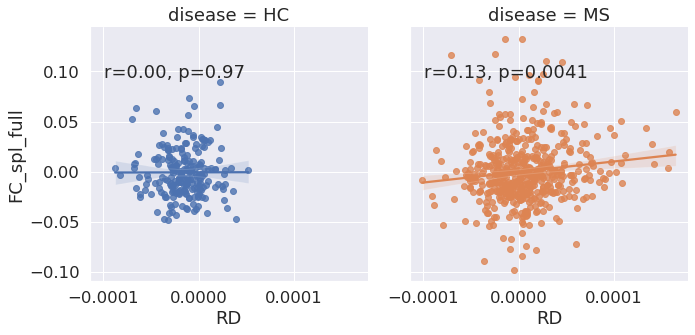

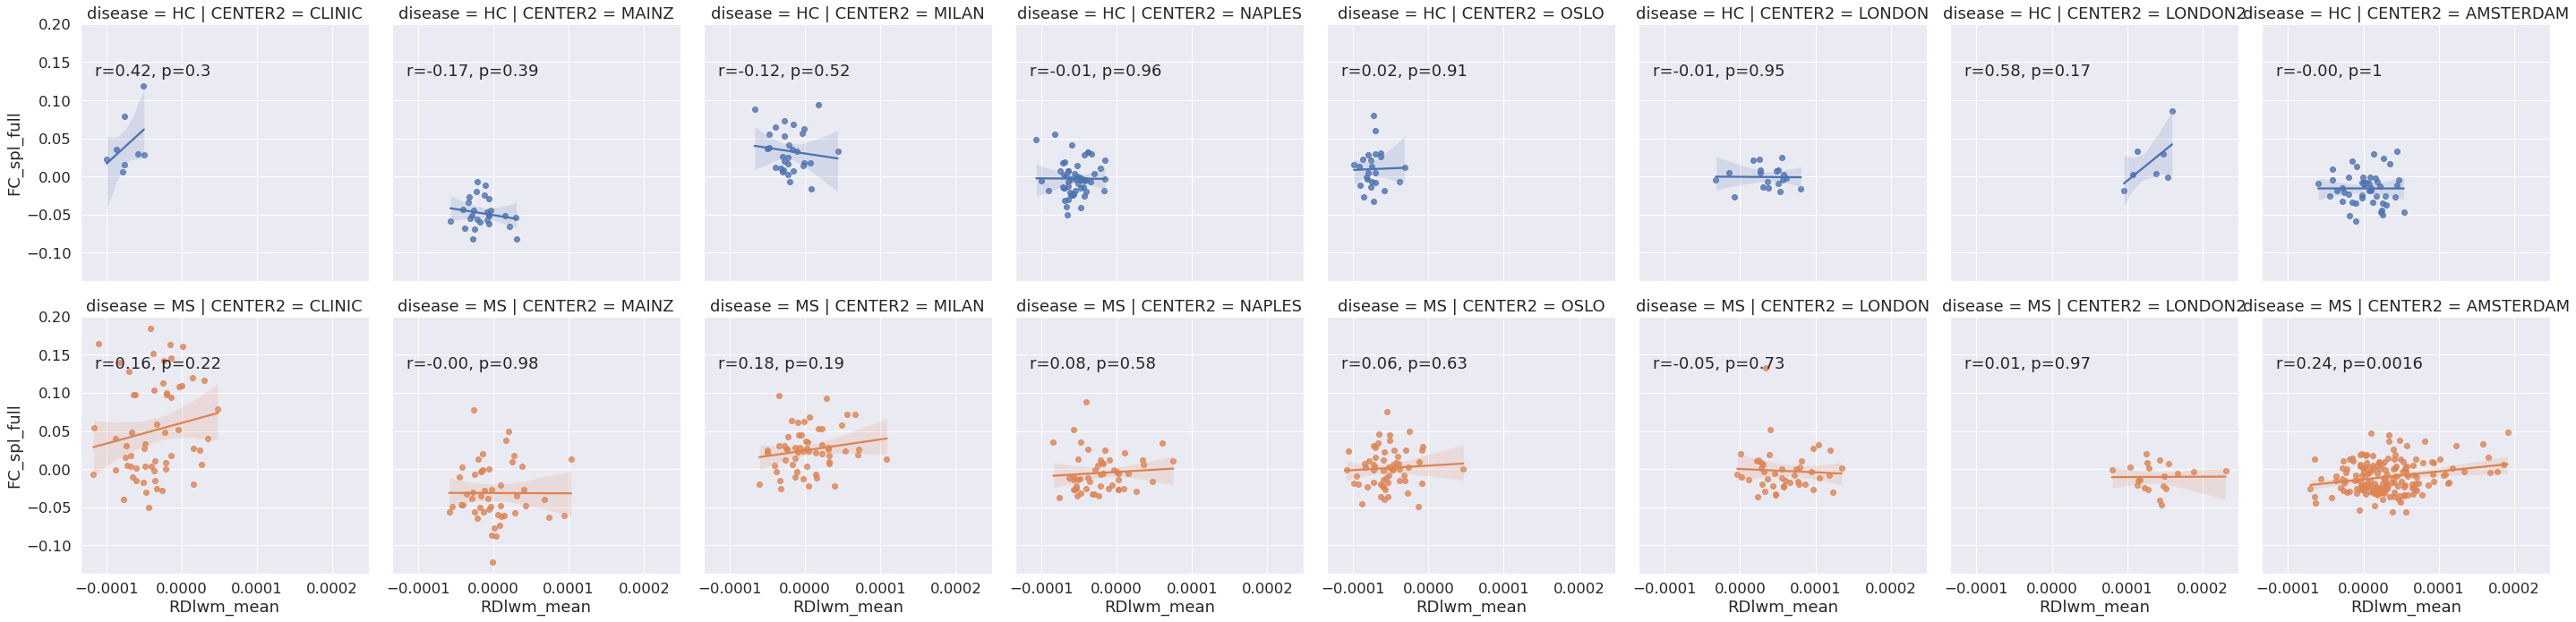

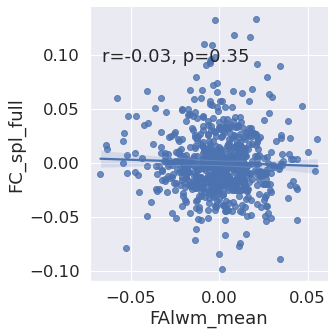

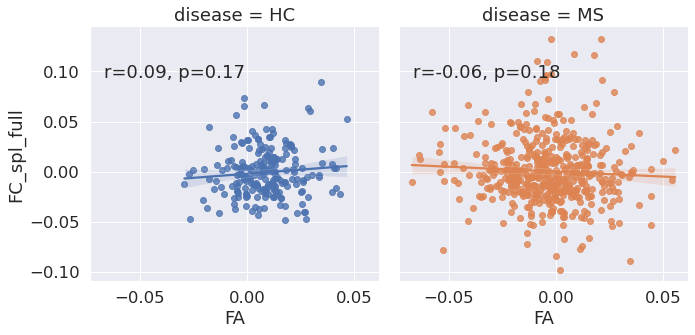

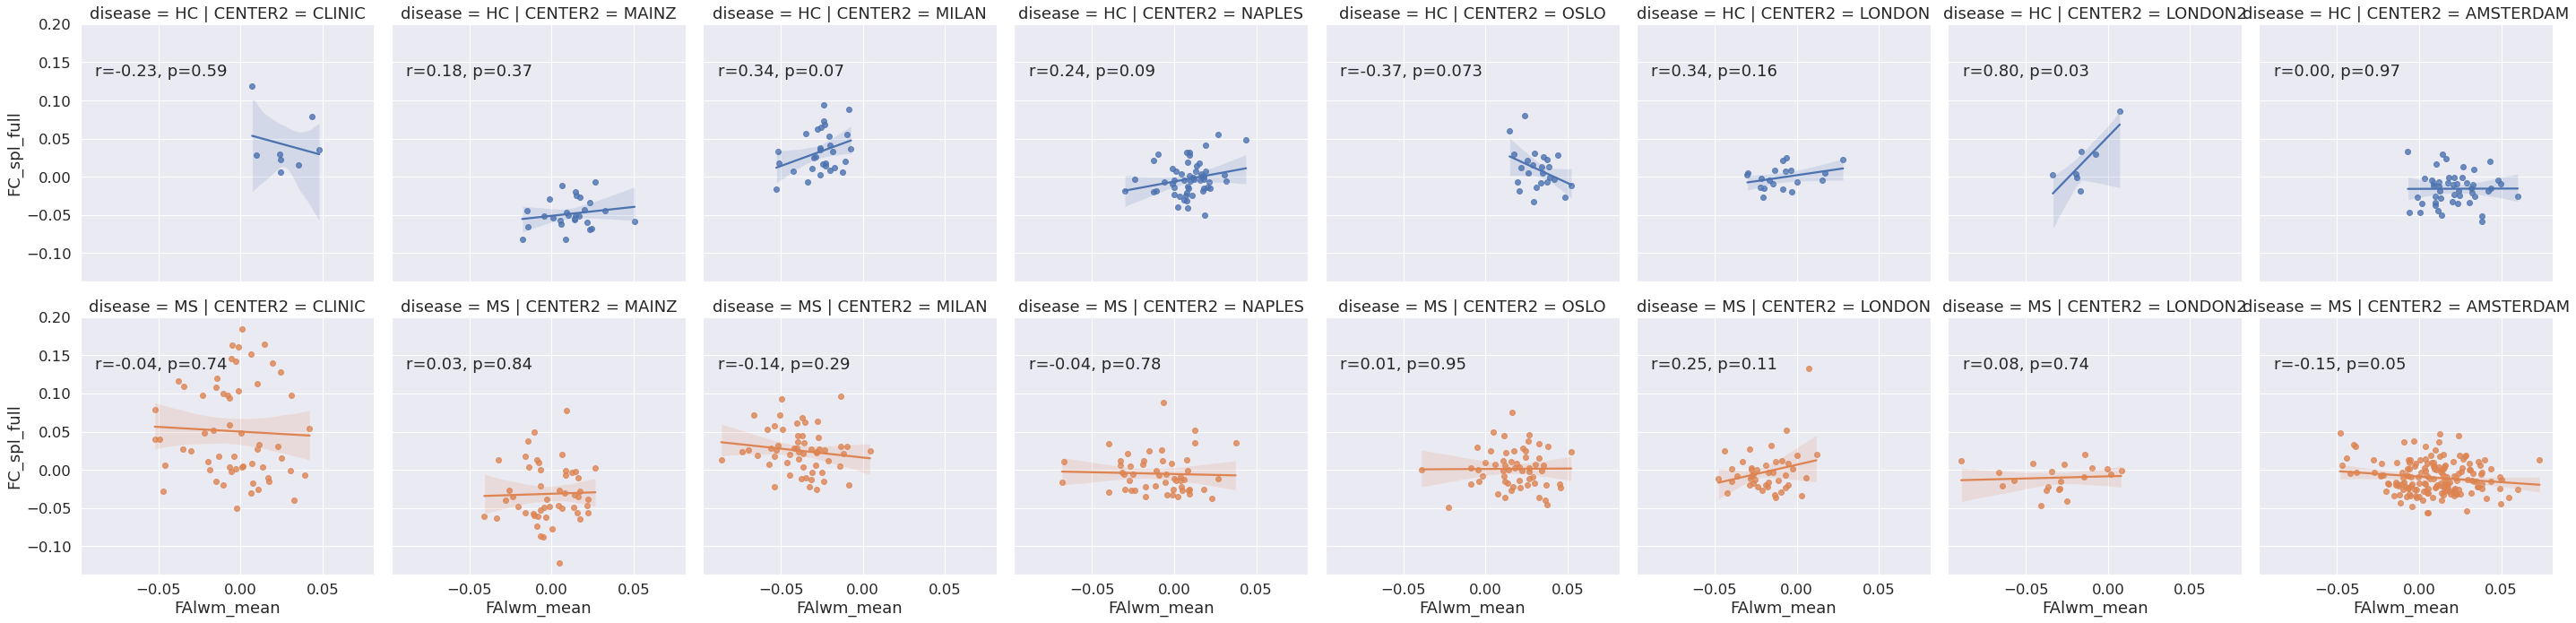

In [8]:
"""
ANALYSIS of the data
Biomarkers to analyze:

Full_CC
Comm_ratio
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

Explicar que és cada variable?  
"""
### Scatterplot G
## Compare different values 

from scipy import stats
sns.set_style("darkgrid")
varx = "dummy"
vary = "FC_spl_full"

def annotate(data, **kws):
    r, p = stats.pearsonr(data[f"{varx}_C"], data[f"{vary}_C"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

# variables = ["EDSS", "SDMT", "DD", "GMF", "BPF", "WMF", "LVF", "RDlwm_mean", "FAlwm_mean"]
variables = ["EDSS", "SDMT", "BPF", "LVF", "RDlwm_mean", "FAlwm_mean"]
sns.set(font_scale = 1.5)

for varx in variables:
    # AGE
    if varx in ["DD", "SDMT", "EDSS"]:
        data_to_plot = df_merged.dropna(subset=[varx])
    
    elif varx == "LVF":
        data_to_plot = df_merged.dropna(subset=[varx])
        data_to_plot = data_to_plot[data_to_plot.LVF < 1.0]
    else:
        data_to_plot = df_merged

    results = smf.ols(f'{varx} ~ AGE + C(SEX) + C(CENTER2)', data=data_to_plot).fit()
    data_to_plot[f"{varx}_C"] = results.resid
    
    results = smf.ols(f'{vary} ~ AGE + C(SEX) + C(CENTER2)', data=data_to_plot).fit()
    data_to_plot[f"{vary}_C"] = results.resid

    g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C")
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()

    if varx in ["DD", "SDMT", "EDSS", "GMF", "BPF", "WMF", "RDlwm_mean", "FAlwm_mean"]:
        g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C", col="disease", hue="disease", hue_order=["HC", "MS"], col_order=["HC", "MS"], sharex=True, sharey=True)
        g.map_dataframe(annotate)
        g.set_axis_labels(varx, vary)
        plt.tight_layout()

    if varx == "RDwm_mean" or varx == "RDlwm_mean": g.set_xlabels("RD")
    if varx == "FAlwm_mean": g.set_xlabels("FA")

    results = smf.ols(f'{varx} ~ AGE + C(SEX)', data=data_to_plot).fit()
    data_to_plot[f"{varx}_C"] = results.resid
    
    results = smf.ols(f'{vary} ~ AGE + C(SEX)', data=data_to_plot).fit()
    data_to_plot[f"{vary}_C"] = results.resid

    g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C", col="CENTER2", row="disease", hue="disease", hue_order=["HC", "MS"], row_order=["HC", "MS"],)
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()




In [9]:
"""
Full_CC
Comm_ratio
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

"""

structural_dmg_vars = ["BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
df_results_glm = pd.DataFrame()
dependent_vars = ["EDSS", "SDMT"]
variable_to_test_for = "FC_spl_full"
type_of_model = "glm" # "logit" or "glm"

for biomarker in structural_dmg_vars:
    
    results_to_save = {}
    for xvar in dependent_vars:
        if xvar in ["DD", "SDMT", "EDSS"]:
            df_figure = df_merged.dropna(subset=[xvar])
        
        elif xvar == "LVF":
            df_figure = df_merged.dropna(subset=[xvar])
            df_figure = df_figure[df_figure.LVF < 1.0]

        #normalize between 0 and 1 the values of the biomarker
        if type_of_model == "logit":
            df_figure[dependent_vars] = (df_figure[dependent_vars] - df_figure[dependent_vars].min()) / (df_figure[dependent_vars].max() - df_figure[dependent_vars].min())

        formula = f'{xvar} ~ {variable_to_test_for} + {biomarker} + AGE + C(SEX) + C(CENTER2)' 

        if type_of_model == "logit":
            results = smf.logit(formula, data=df_figure).fit()
        elif type_of_model == "glm":
            results = smf.glm(formula, data=df_figure).fit()
        else: results = "NA"
        tstat = results.tvalues[variable_to_test_for] # tstat value for the test, biomarker
        pval = results.pvalues[variable_to_test_for] # pval for the test, bimoarker

        str_save = f"t={tstat:.3f}, p={pval:.3f}"
        
        results = smf.ols(f'{variable_to_test_for} ~ {biomarker} + AGE + C(SEX) + C(CENTER2)', data=df_figure).fit()
        df_figure[f"{variable_to_test_for}_C"] = results.resid
        
        results = smf.ols(f'{xvar} ~ {biomarker} + AGE + C(SEX) + C(CENTER2)', data=df_figure).fit()
        df_figure[f"{biomarker}_C"] = results.resid

        r, p = stats.pearsonr(df_figure[f"{variable_to_test_for}_C"], df_figure[f"{biomarker}_C"])
        str_save = f"r={r:.3f}, p={p:.3f}"
        
        results_to_save[xvar] = str_save

    df_results_glm = df_results_glm.append({'Biomarker': biomarker, 'EDSS': results_to_save["EDSS"], 'SDMT': results_to_save["SDMT"]}, ignore_index=True)

# remove index from df
df_results_glm = df_results_glm.reset_index(drop=True)
display(df_results_glm)


,Biomarker,EDSS,SDMT
0,BPF,"r=0.106, p=0.017","r=0.001, p=0.974"
1,GMF,"r=0.109, p=0.014","r=-0.009, p=0.831"
2,WMF,"r=0.106, p=0.017","r=0.003, p=0.945"
3,LVF,"r=0.115, p=0.010","r=-0.021, p=0.619"
4,RDwm_mean,"r=0.084, p=0.060","r=0.027, p=0.525"
5,FAwm_mean,"r=0.101, p=0.023","r=0.001, p=0.983"


In [10]:
"""
Full_CC
Comm_ratio_approx
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

"""
print(df_merged["CENTER2"])
# direct linear model
structural_dmg_vars = ["EDSS", "SDMT", "BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
dependent_vars = ["Full_hemis", "Comm_ratio", "CC_ratio_area", "FC_eff_full", "FC_spl_full"]

## linear models accounting for structural dmg
# structural_dmg_vars = ["BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
# dependent_vars = ["EDSS", "SDMT"]
df_results_glm = pd.DataFrame()
variable_to_test_for = "CC_ratio_area"
type_of_model = "glm" # "logit" or "glm"

for biomarker in structural_dmg_vars:
    results_to_save = {}
    for xvar in dependent_vars:
        df_figure = df_merged.dropna(subset=[biomarker,xvar])

        #normalize between 0 and 1 the values of the biomarker
        if type_of_model == "logit":
            df_figure[dependent_vars] = (df_figure[dependent_vars] - df_figure[dependent_vars].min()) / (df_figure[dependent_vars].max() - df_figure[dependent_vars].min())

        formula = f'{biomarker} ~ {xvar} + AGE + C(SEX) + C(CENTER2)' 

        if type_of_model == "logit":
            results = smf.logit(formula, data=df_figure).fit()
        elif type_of_model == "glm":
            results = smf.ols(formula, data=df_figure).fit()
        else: results = "NA"
        tstat = results.tvalues[xvar] # tstat value for the test, biomarker
        pval = results.pvalues[xvar] # pval for the test, bimoarker

        str_save = f"t={tstat:.3f}, p={pval:.3f}"

        results = smf.ols(f'{biomarker} ~ AGE + C(SEX) + C(CENTER2)', data=df_figure).fit()
        df_figure[f"{biomarker}_C"] = results.resid
        
        results = smf.ols(f'{xvar} ~ AGE + C(SEX) + C(CENTER2)', data=df_figure).fit()
        df_figure[f"{xvar}_C"] = results.resid

        r, p = stats.pearsonr(df_figure[f"{biomarker}_C"], df_figure[f"{xvar}_C"])
        str_save = f"r={r:.3f}, p={p:.3f}"

        results_to_save[xvar] = str_save

    df_results_glm = df_results_glm.append({'Biomarker': biomarker, 'Full_hemis': results_to_save["Full_hemis"], 'Comm_ratio': results_to_save["Comm_ratio"], 'CC_ratio_area': results_to_save["CC_ratio_area"],
                                            'FC_eff_full': results_to_save["FC_eff_full"], 'FC_spl_full': results_to_save["FC_spl_full"]}, ignore_index=True)

# remove index from df
df_results_glm = df_results_glm.reset_index(drop=True)
display(df_results_glm)


0         CLINIC
1         CLINIC
2         CLINIC
3         CLINIC
4         CLINIC
         ...    
733    AMSTERDAM
734    AMSTERDAM
735    AMSTERDAM
736    AMSTERDAM
737    AMSTERDAM
Name: CENTER2, Length: 725, dtype: object


,Biomarker,CC_ratio_area,Comm_ratio,FC_eff_full,FC_spl_full,Full_hemis
0,EDSS,"r=-0.147, p=0.001","r=-0.162, p=0.000","r=-0.106, p=0.017","r=0.112, p=0.012","r=-0.069, p=0.120"
1,SDMT,"r=0.308, p=0.000","r=0.220, p=0.000","r=0.017, p=0.676","r=-0.017, p=0.687","r=0.111, p=0.007"
2,BPF,"r=0.193, p=0.000","r=0.377, p=0.000","r=0.058, p=0.119","r=-0.056, p=0.132","r=0.073, p=0.050"
3,GMF,"r=-0.012, p=0.751","r=0.185, p=0.000","r=0.051, p=0.167","r=-0.047, p=0.202","r=-0.076, p=0.041"
4,WMF,"r=0.338, p=0.000","r=0.461, p=0.000","r=0.049, p=0.187","r=-0.049, p=0.184","r=0.195, p=0.000"
5,LVF,"r=-0.228, p=0.000","r=-0.426, p=0.000","r=0.022, p=0.562","r=-0.020, p=0.585","r=-0.218, p=0.000"
6,RDwm_mean,"r=-0.310, p=0.000","r=-0.452, p=0.000","r=-0.099, p=0.008","r=0.109, p=0.003","r=-0.118, p=0.002"
7,FAwm_mean,"r=0.298, p=0.000","r=0.436, p=0.000","r=0.028, p=0.452","r=-0.035, p=0.348","r=0.127, p=0.001"


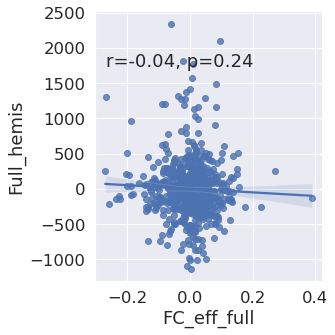

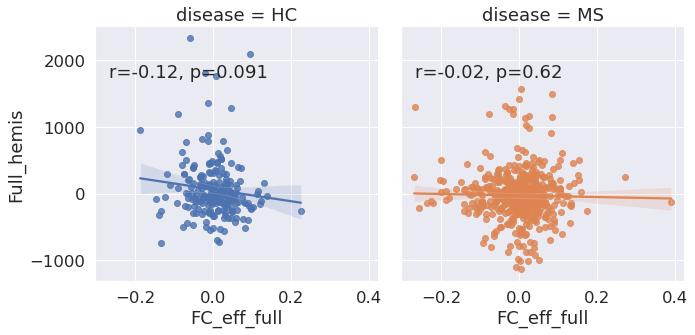

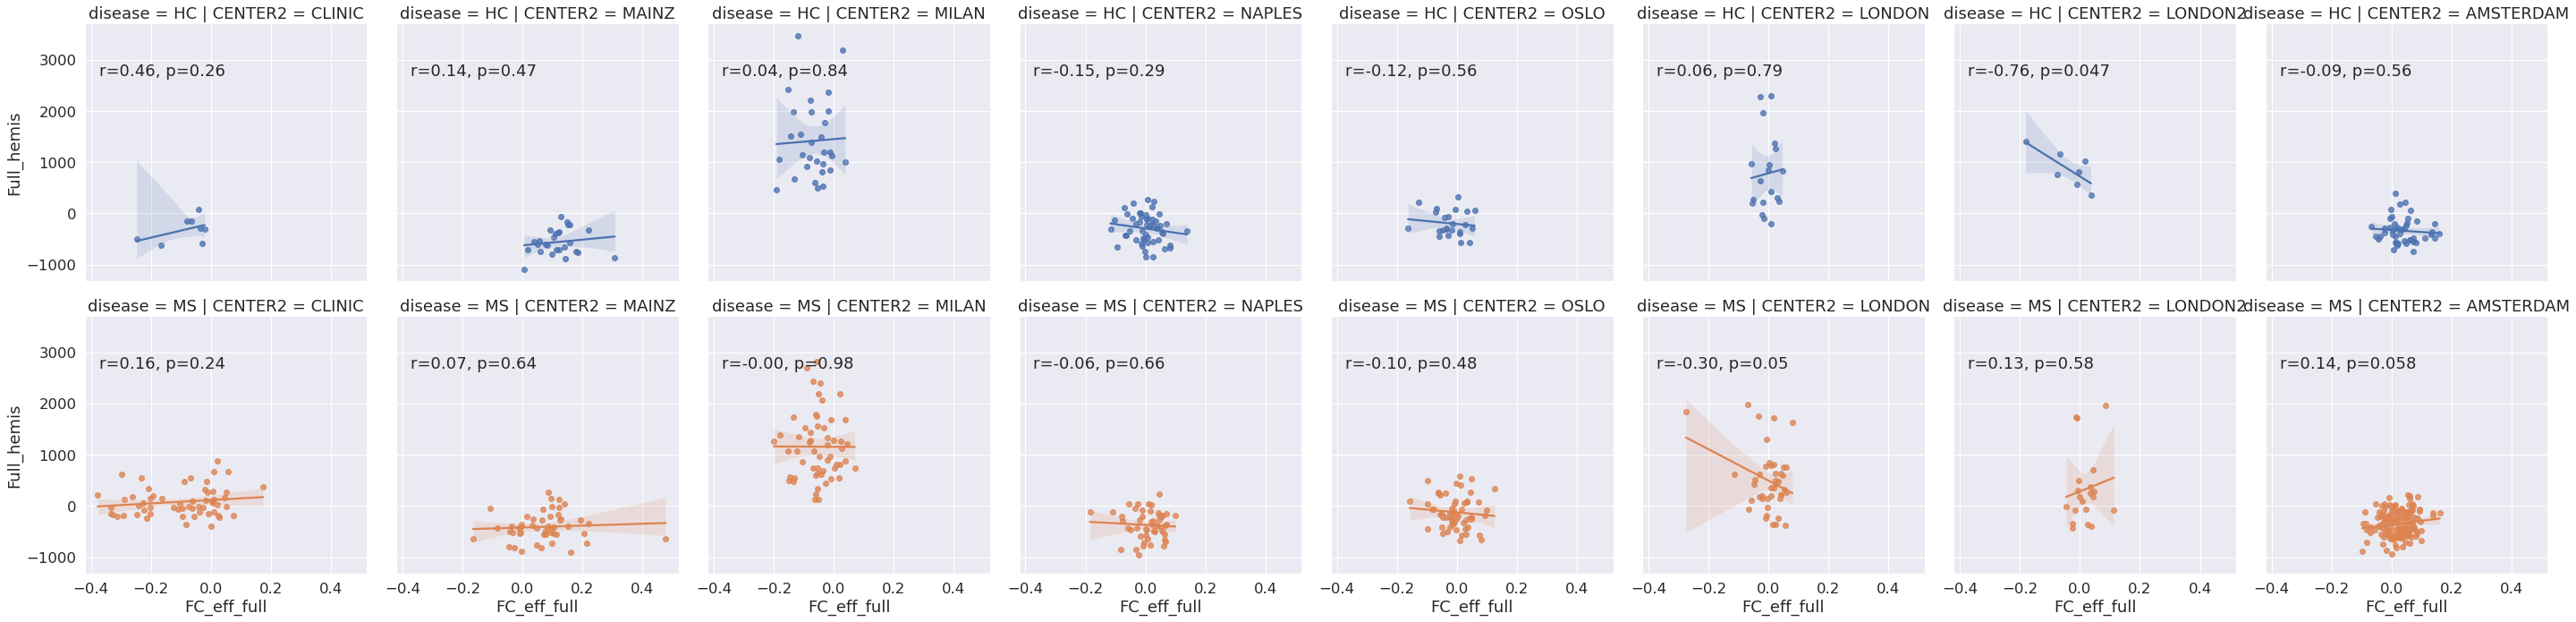

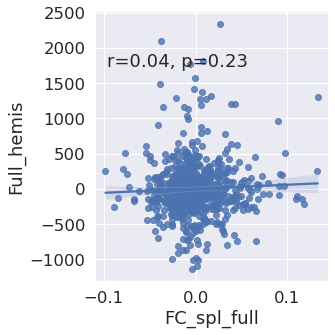

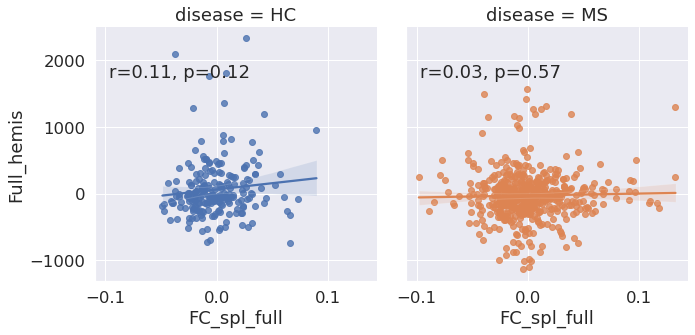

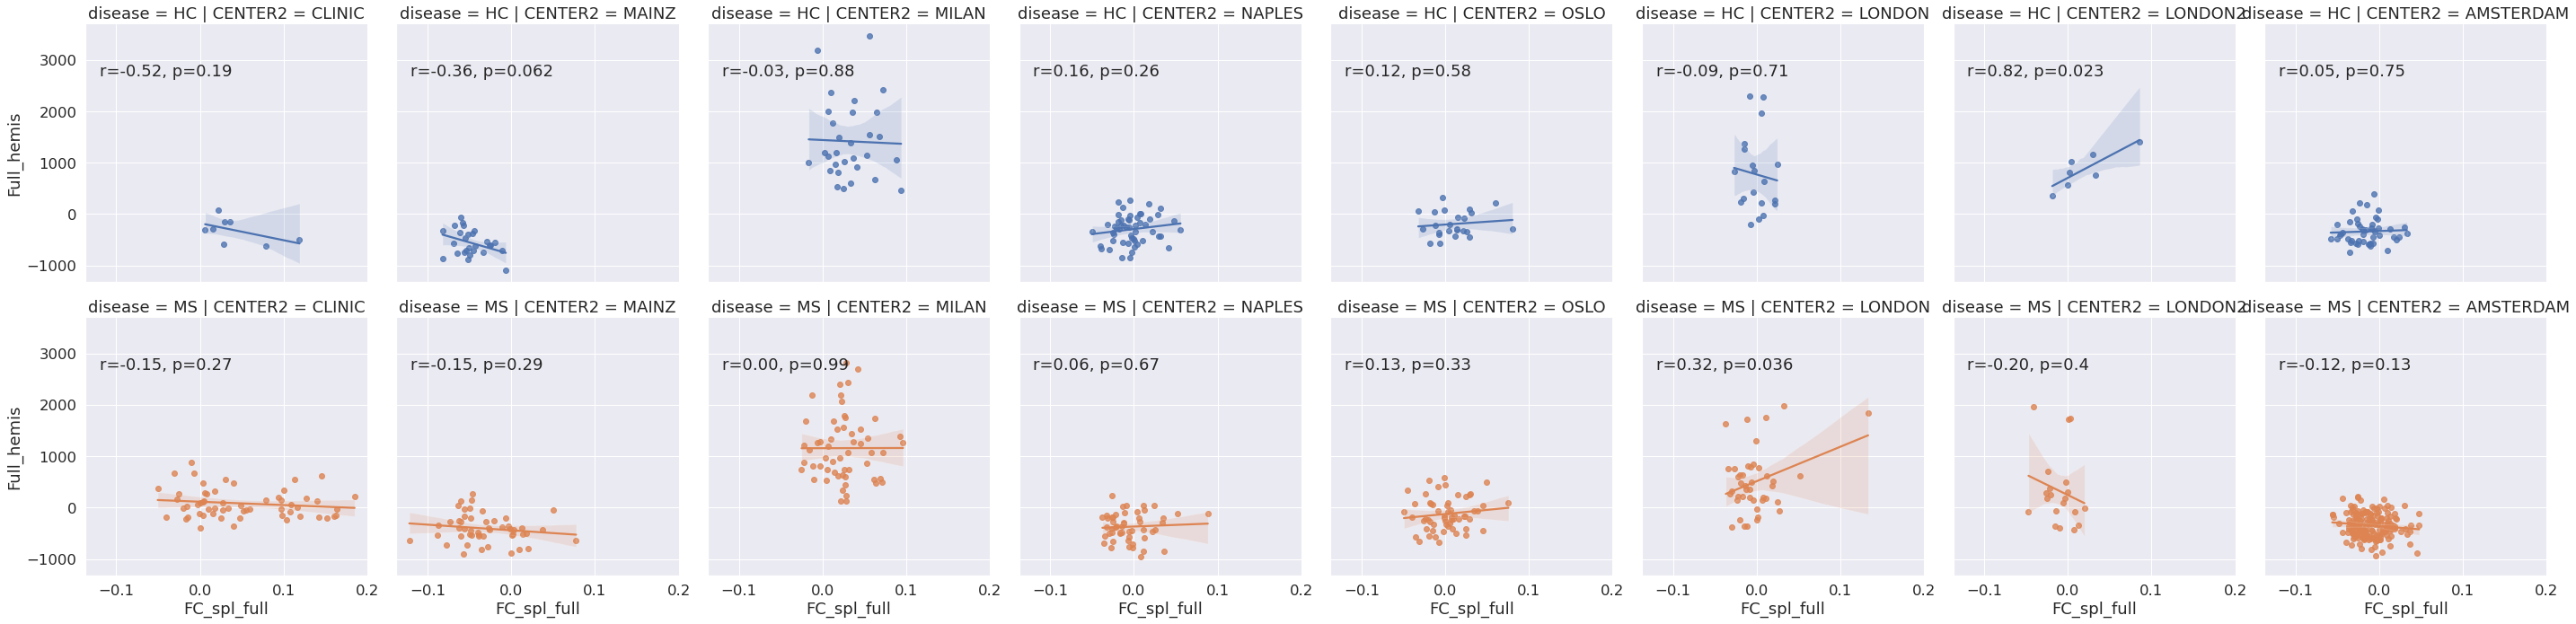

In [11]:
"""
ANALYSIS of the data
Biomarkers to analyze:

Full_CC
Comm_ratio
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

Explicar que és cada variable?  
"""
### Scatterplot G
## Compare different values 

from scipy import stats
sns.set_style("darkgrid")
varx = "dummy"
vary = "Full_hemis"

def annotate(data, **kws):
    r, p = stats.pearsonr(data[f"{varx}_C"], data[f"{vary}_C"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

# variables = ["EDSS", "SDMT", "DD", "GMF", "BPF", "WMF", "LVF", "RDlwm_mean", "FAlwm_mean"]
variables = ["FC_eff_full", "FC_spl_full"]
sns.set(font_scale = 1.5)

for varx in variables:
    # AGE
    if varx in ["DD", "SDMT", "EDSS"]:
        data_to_plot = df_merged.dropna(subset=[varx])
    
    elif varx == "LVF":
        data_to_plot = df_merged.dropna(subset=[varx])
        data_to_plot = data_to_plot[data_to_plot.LVF < 1.0]
    else:
        data_to_plot = df_merged

    results = smf.ols(f'{varx} ~ AGE + C(SEX) + C(CENTER2)', data=data_to_plot).fit()
    data_to_plot[f"{varx}_C"] = results.resid
    
    results = smf.ols(f'{vary} ~ AGE + C(SEX) + C(CENTER2)', data=data_to_plot).fit()
    data_to_plot[f"{vary}_C"] = results.resid

    g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C")
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()

    if varx in ["FC_eff_full", "FC_spl_full"]:
        g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C", col="disease", hue="disease", hue_order=["HC", "MS"], col_order=["HC", "MS"], sharex=True, sharey=True)
        g.map_dataframe(annotate)
        g.set_axis_labels(varx, vary)
        plt.tight_layout()

    if varx == "RDwm_mean" or varx == "RDlwm_mean": g.set_xlabels("RD")
    if varx == "FAlwm_mean": g.set_xlabels("FA")

    results = smf.ols(f'{varx} ~ AGE + C(SEX)', data=data_to_plot).fit()
    data_to_plot[f"{varx}_C"] = results.resid
    
    results = smf.ols(f'{vary} ~ AGE + C(SEX)', data=data_to_plot).fit()
    data_to_plot[f"{vary}_C"] = results.resid

    g = sns.lmplot(data=data_to_plot, x=f"{varx}_C", y=f"{vary}_C", col="CENTER2", row="disease", hue="disease", hue_order=["HC", "MS"], row_order=["HC", "MS"],)
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()




In [12]:
"""
Full_CC
Comm_ratio_approx
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

"""
print(df_merged["CENTER2"])
# direct linear model
structural_dmg_vars = ["FC_eff_full", "FC_spl_full"]
dependent_vars = ["Full_hemis", "Comm_ratio", "CC_ratio_area"]

## linear models accounting for structural dmg
# structural_dmg_vars = ["BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
# dependent_vars = ["EDSS", "SDMT"]
df_results_glm = pd.DataFrame()
variable_to_test_for = "CC_ratio_area"
type_of_model = "glm" # "logit" or "glm"

for biomarker in structural_dmg_vars:
    
    results_to_save = {}
    for xvar in dependent_vars:
        df_figure = df_merged.dropna(subset=[biomarker])

        #normalize between 0 and 1 the values of the biomarker
        if type_of_model == "logit":
            df_figure[dependent_vars] = (df_figure[dependent_vars] - df_figure[dependent_vars].min()) / (df_figure[dependent_vars].max() - df_figure[dependent_vars].min())

        formula = f'{biomarker} ~ {xvar} + AGE + C(SEX) + C(CENTER2)' 

        if type_of_model == "logit":
            results = smf.logit(formula, data=df_figure).fit()
        elif type_of_model == "glm":
            results = smf.ols(formula, data=df_figure).fit()
        else: results = "NA"
        tstat = results.tvalues[xvar] # tstat value for the test, biomarker
        pval = results.pvalues[xvar] # pval for the test, bimoarker
        str_save = f"t={tstat:.3f}, p={pval:.3f}"

        results_to_save[xvar] = str_save

    df_results_glm = df_results_glm.append({'Biomarker': biomarker, 'Full_hemis': results_to_save["Full_hemis"], 'Comm_ratio': results_to_save["Comm_ratio"], 'CC_ratio_area': results_to_save["CC_ratio_area"]}, ignore_index=True)

# remove index from df
df_results_glm = df_results_glm.reset_index(drop=True)
display(df_results_glm)


0         CLINIC
1         CLINIC
2         CLINIC
3         CLINIC
4         CLINIC
         ...    
733    AMSTERDAM
734    AMSTERDAM
735    AMSTERDAM
736    AMSTERDAM
737    AMSTERDAM
Name: CENTER2, Length: 725, dtype: object


,Biomarker,CC_ratio_area,Comm_ratio,Full_hemis
0,FC_eff_full,"t=-0.964, p=0.335","t=-0.028, p=0.978","t=-1.173, p=0.241"
1,FC_spl_full,"t=1.012, p=0.312","t=-0.062, p=0.951","t=1.186, p=0.236"


In [13]:
"""
Full_CC
Comm_ratio
CC_ratio_area
Full_hemis
FC_eff_full
FC_spl_full

"""
### PER CENTER

structural_dmg_vars = ["EDSS", "SDMT", "BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
dependent_var = "SDMT" #"EDSS", "SDMT"
variable_to_test_for = "Full_hemis"
type_of_model = "glm" # "logit" or "glm"

df_results_c = pd.DataFrame()
for center in df_merged.CENTER2.unique():
    
    results_to_save = {}
    for biomarker in structural_dmg_vars:
    
        df_figure = df_merged[df_merged.CENTER2 == center]
        df_figure = df_figure.dropna(subset=[biomarker])
        #normalize between 0 and 1 the values of the biomarker  
        if type_of_model == "logit":
            df_figure[dependent_var] = (df_figure[dependent_var] - df_figure[dependent_var].min()) / (df_figure[dependent_var].max() - df_figure[dependent_var].min())
        formula = f'{biomarker} ~ {variable_to_test_for} + AGE + C(SEX)' 
        if type_of_model == "logit":
            results = smf.logit(formula, data=df_figure).fit()
        elif type_of_model == "glm":
            results = smf.ols(formula, data=df_figure).fit()
        else: results = "NA"

        tstat = results.tvalues[variable_to_test_for] # tstat value for the test, biomarker
        pval = results.pvalues[variable_to_test_for] # pval for the test, biomarker
        str_save = f"t={tstat:.3f}, p={pval:.3f}"

        results = smf.ols(f'{biomarker} ~ AGE + C(SEX)', data=df_figure).fit()
        df_figure[f"{biomarker}_C"] = results.resid
        
        results = smf.ols(f'{variable_to_test_for} ~ AGE + C(SEX)', data=df_figure).fit()
        df_figure[f"{variable_to_test_for}_C"] = results.resid

        r, p = stats.pearsonr(df_figure[f"{biomarker}_C"], df_figure[f"{variable_to_test_for}_C"])
        str_save = f"r={r:.3f}, p={p:.3f}"
        results_to_save[biomarker] = str_save

    results_to_save["CENTER"] = center
    df_results_c = df_results_c.append(results_to_save, ignore_index=True)
    
#display(df_results_glm.groupby(by="CENTER"))
#set CENTER as the index
df_results_c = df_results_c.set_index("CENTER")
#reorder biomarker column as structural_dmg_vars
df_results_c = df_results_c[structural_dmg_vars]
#  reorder rows as in [CLINIC MAINZ OSLO MILAN NAPLES LONDON AMSTERDAM] in center
df_results_c = df_results_c.reindex(["CLINIC", "MAINZ", "OSLO", "MILAN", "NAPLES", "LONDON", "LONDON2", "AMSTERDAM"])
display(df_results_c.T)

CENTER,CLINIC,MAINZ,OSLO,MILAN,NAPLES,LONDON,LONDON2,AMSTERDAM
EDSS,"r=-0.113, p=0.398","r=-0.032, p=0.832","r=-0.015, p=0.913","r=-0.206, p=0.128","r=-0.056, p=0.697","r=0.024, p=0.880","r=-0.162, p=0.496","r=0.164, p=0.031"
SDMT,"r=0.088, p=0.509","r=0.264, p=0.091","r=0.016, p=0.903","r=0.160, p=0.144","r=-0.115, p=0.422","r=0.195, p=0.209","r=0.198, p=0.402","r=0.021, p=0.762"
BPF,"r=0.078, p=0.534","r=-0.100, p=0.386","r=0.039, p=0.728","r=0.207, p=0.055","r=0.076, p=0.445","r=0.210, p=0.101","r=-0.014, p=0.943","r=0.005, p=0.937"
GMF,"r=-0.048, p=0.699","r=-0.308, p=0.006","r=-0.169, p=0.129","r=-0.118, p=0.278","r=-0.098, p=0.322","r=0.083, p=0.519","r=-0.095, p=0.638","r=-0.158, p=0.019"
WMF,"r=0.160, p=0.200","r=0.161, p=0.161","r=0.287, p=0.009","r=0.393, p=0.000","r=0.228, p=0.020","r=0.313, p=0.013","r=0.111, p=0.581","r=0.147, p=0.029"
LVF,"r=-0.044, p=0.728","r=0.065, p=0.577","r=0.120, p=0.284","r=-0.258, p=0.016","r=-0.023, p=0.821","r=-0.331, p=0.009","r=-0.310, p=0.115","r=0.015, p=0.829"
RDwm_mean,"r=-0.115, p=0.359","r=-0.058, p=0.615","r=-0.038, p=0.736","r=-0.302, p=0.005","r=-0.165, p=0.094","r=-0.185, p=0.151","r=-0.045, p=0.822","r=-0.010, p=0.884"
FAwm_mean,"r=0.006, p=0.963","r=0.106, p=0.358","r=0.118, p=0.292","r=0.234, p=0.030","r=0.195, p=0.047","r=0.155, p=0.230","r=0.429, p=0.025","r=0.012, p=0.864"
